In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
from argparse import ArgumentParser
import os
import cv2

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/with_mask/
  inflating: dataset/with_mask/0-with-mask.jpg  
  inflating: dataset/with_mask/1-with-mask.jpg  
  inflating: dataset/with_mask/10-with-mask.jpg  
  inflating: dataset/with_mask/100-with-mask.jpg  
  inflating: dataset/with_mask/101-with-mask.jpg  
  inflating: dataset/with_mask/103-with-mask.jpg  
  inflating: dataset/with_mask/104-with-mask.jpg  
  inflating: dataset/with_mask/105-with-mask.jpg  
  inflating: dataset/with_mask/106-with-mask.jpg  
  inflating: dataset/with_mask/107-with-mask.jpg  
  inflating: dataset/with_mask/108-with-mask.jpg  
  inflating: dataset/with_mask/109-with-mask.jpg  
  inflating: dataset/with_mask/11-with-mask.jpg  
  inflating: dataset/with_mask/110-with-mask.jpg  
  inflating: dataset/with_mask/111-with-mask.jpg  
  inflating: dataset/with_mask/112-with-mask.jpg  
  inflating: dataset/with_mask/113-with-mask.jpg  
  inflating: dataset/with_mask/114-with-mask.jpg  
  inflating:

In [ ]:
imagePaths = list(paths.list_images('/content/dataset'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
len(labels)

1376

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 1s 0us/step


In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
34/34 [==============================] - 50s 1s/step - loss: 0.4885 - accuracy: 0.7818 - val_loss: 0.1297 - val_accuracy: 0.9746
Epoch 2/20
34/34 [==============================] - 50s 1s/step - loss: 0.1510 - accuracy: 0.9494 - val_loss: 0.0557 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 50s 1s/step - loss: 0.0826 - accuracy: 0.9831 - val_loss: 0.0361 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 50s 1s/step - loss: 0.0593 - accuracy: 0.9831 - val_loss: 0.0288 - val_accuracy: 0.9891
Epoch 5/20
34/34 [==============================] - 50s 1s/step - loss: 0.0463 - accuracy: 0.9888 - val_loss: 0.0253 - val_accuracy: 0.9891
Epoch 6/20
34/34 [==============================] - 49s 1s/step - loss: 0.0359 - accuracy: 0.9916 - val_loss: 0.0238 - val_accuracy: 0.9891
Epoch 7/20
34/34 [==============================] - 51s 1s/step - loss: 0.0311 - accuracy: 0.9906 - val_loss: 

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       138
           1       0.99      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



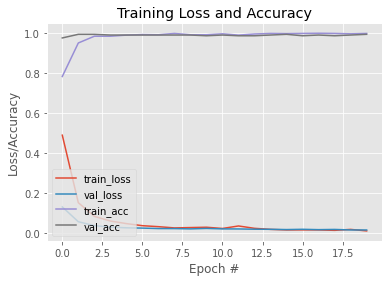

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
#To save the trained model
model.save('mask_recog_ver2.h5')

In [ ]:
#train the saved model again 
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10})

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
34/34 [==============================] - 50s 1s/step - loss: 0.0282 - accuracy: 0.9953 - val_loss: 0.0152 - val_accuracy: 0.9928
Epoch 2/20
34/34 [==============================] - 50s 1s/step - loss: 0.0216 - accuracy: 0.9981 - val_loss: 0.0244 - val_accuracy: 0.9891
Epoch 3/20
34/34 [==============================] - 50s 1s/step - loss: 0.0116 - accuracy: 0.9972 - val_loss: 0.0110 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 50s 1s/step - loss: 0.0231 - accuracy: 0.9953 - val_loss: 0.0130 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 49s 1s/step - loss: 0.0117 - accuracy: 0.9991 - val_loss: 0.0161 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 49s 1s/step - loss: 0.0117 - accuracy: 0.9981 - val_loss: 0.0150 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 49s 1s/step - loss: 0.0280 - accuracy: 0.9944 - val_loss: 

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       138
           1       1.00      0.99      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



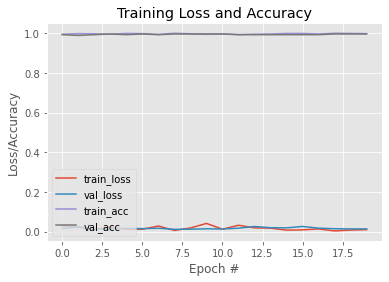

In [ ]:
#Evaluate the model again
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

In [40]:
cascPath = os.path.dirname(
    cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
faceCascade = cv2.CascadeClassifier(cascPath)
model = load_model("mask_recog_ver2.h5")
img = cv2.imread('/content/Untitled.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(60, 60),
                                         flags=cv2.CASCADE_SCALE_IMAGE)

faces_list=[]
preds=[]
for (x, y, w, h) in faces:
        face_frame = img[y:y+h,x:x+w]
        face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
        face_frame = cv2.resize(face_frame, (224, 224))
        face_frame = img_to_array(face_frame)
        face_frame = np.expand_dims(face_frame, axis=0)
        face_frame =  preprocess_input(face_frame)
        faces_list.append(face_frame)
        if len(faces_list)>0:
            preds = model.predict(faces_list)
        for pred in preds:
        #mask contain probabily of wearing a mask and vice versa
          (mask, withoutMask) = pred 

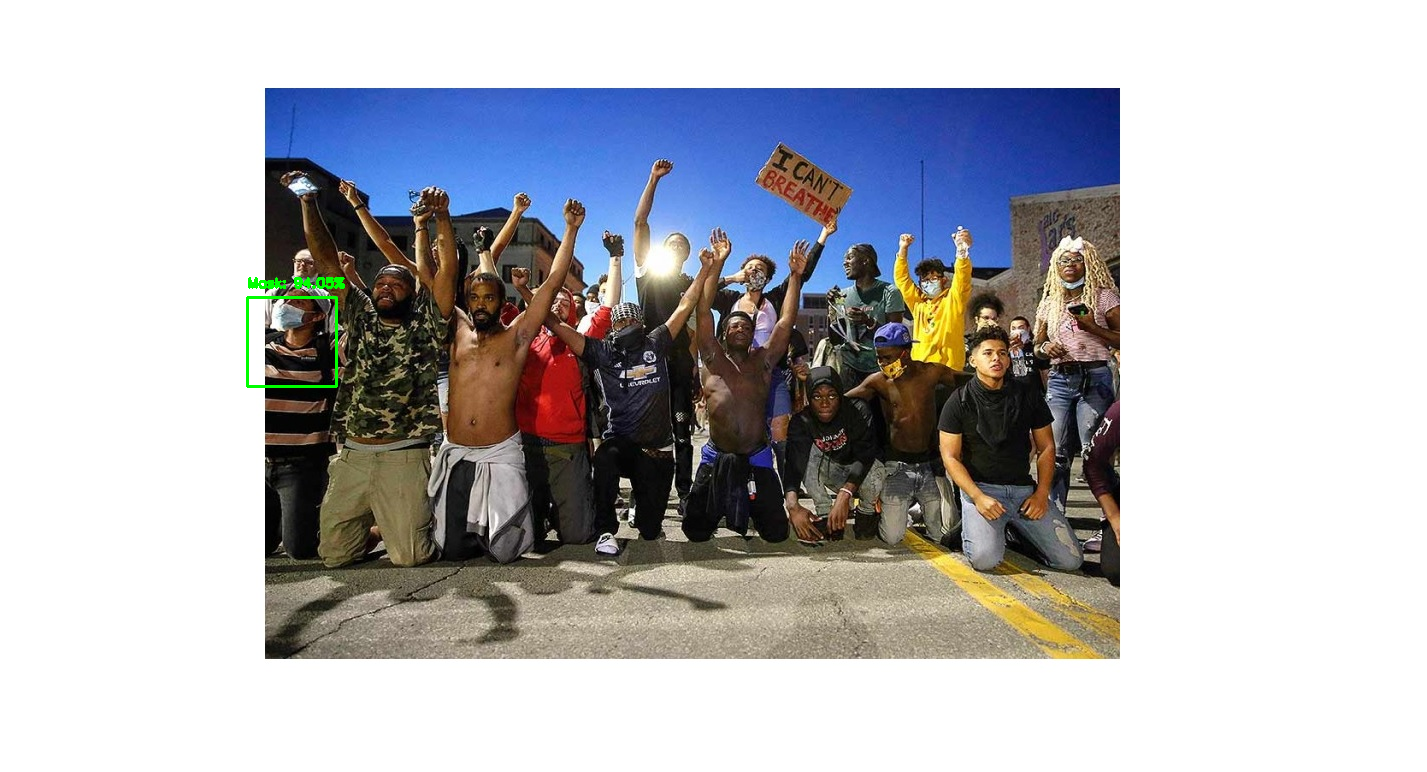

-1

In [ ]:
label = "Mask" if mask > withoutMask else "No Mask"
color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
cv2.putText(img, label, (x, y- 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
cv2.rectangle(img, (x, y), (x + w, y + h),color, 2)
cv2_imshow(img)
cv2.waitKey(0)